In [ ]:
import pandas as pd 
import numpy as np
from src.download import *
import zipfile 
import glob
from tqdm import tqdm  
import os
from src.files.fasta import FASTAFile
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import entropy 
import re
import subprocess
import math 
from utils import * 
from src.data import *
import matplotlib.cm 
import matplotlib.colors
from scipy.stats import chisquare
from scipy.spatial.distance import cdist
from src.codons import get_stop_codon_info
import src.tools as tools
from Bio import Phylo
from src.coev import get_scores

%load_ext autoreload
%autoreload 2


In [ ]:
arf1_df = pd.read_csv('../data/arf1_cleaned.csv', index_col=0)

# build_stop_codon_dataset(arf1_df.genome_id.unique())
stop_codon_df = pd.read_csv('../data/stop_codon.csv', index_col=0)

arf1_df['tag_count'] = arf1_df.genome_id.map(stop_codon_df.groupby('genome_id').TAG.first())
arf1_df['stop_codon_count'] = arf1_df.genome_id.map(stop_codon_df.groupby('genome_id')['total'].first())
arf1_df['tag_percent'] = arf1_df.tag_count / arf1_df.stop_codon_count 


In [6]:
# Downloaded and ran Prodigal on two genomes of Methanosarcina which (1) had Pyl (2) lost Pyl, and (3) 
# had their TAG usage revert back to the original form. If modifications in the release factor do play a role in 
# total re-coding, we would expect specific, conserved changes between aRF1 of these organisms and their closest relative_ids. 

def add_weird_genomes(arf1_df, genome_ids=['GCA_003164755.1', 'GCA_017883485.1']):
    arf1_ids = {'GCA_017883485.1':'JADGNM010000028.1_7',  'GCA_003164755.1':'PLUB01000075.1_62'} # From inspection of hmmer output files.
    df = list()
    for genome_id in genome_ids:
        fn_path = f'../data/{genome_id}.fna'
        fa_path = f'../data/{genome_id}.fa'

        row = {'genome_id':genome_id, 'id':arf1_ids.get(genome_id), 'description':''}
        row['has_pyl'] = False
        row['order'] = 'Methanosarcinales'
        row['genus'] = 'Methanosarcina'
        stop_codon_info = get_stop_codon_info(fa_path=fa_path, fn_path=fn_path)
        row['tag_percent'] = stop_codon_info['TAG'] / (stop_codon_info['TAG'] + stop_codon_info['TGA'] + stop_codon_info['TAA'])
        row['gc_content'] = stop_codon_info['gc_content']
        row['seq'] = FASTAFile().from_fasta(fa_path).to_df().loc[row['id']].seq
        df.append(row)
    df = pd.DataFrame(df).set_index('id')
    arf1_df = pd.concat([df, arf1_df])
    arf1_df = arf1_df[~arf1_df.index.duplicated(keep='first')].copy() # Make sure to not re-add if added. 
    return arf1_df

arf1_df = add_weird_genomes(arf1_df)

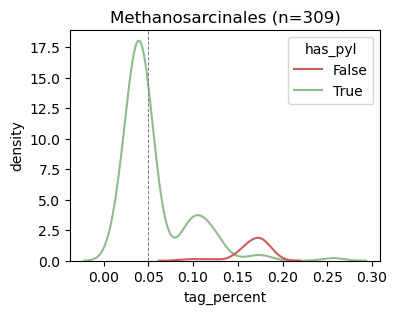

In [8]:
fig, ax = plt.subplots(figsize=(4, 3))

stop_codons = ['TAA', 'TGA', 'TAG']
palette = {True:'darkseagreen', False:'indianred'}

figure_df = arf1_df.copy()
figure_df = figure_df[figure_df.order == 'Methanosarcinales'].copy()
sns.kdeplot(figure_df, x='tag_percent', hue='has_pyl', palette=palette)
ax.set_ylabel('density')
ax.axvline(x=0.05, ls='--', color='gray', lw=0.7)
ax.set_title(f'Methanosarcinales (n={len(figure_df)})')

plt.show()

# Among Pyl+ archaea, when the TAG content drops below 5%, the extension length spikes. This seems like a reasonable threshold for 
# choosing organisms which might have aRF1 changes. 
 
# When the TAG content is higher, the extension lengths are generally lower. In this scenario, we might not expect the 
# release factor to look very different. Genomes are robust to Pyl incorporation and stop codon readthrough. 

# When the TAG content is lower, extension lengths are higher. In these genomes, it may
# be the case that the genomes have fully adapted to frequent Pyl; these are probably the "recoded" genomes.

In [ ]:
methanosarcinales_arf1_df = arf1_df[arf1_df.order == 'Methanosarcinales'].copy()
FASTAFile().from_df(methanosarcinales_arf1_df).write('../data/methanosarcinales_arf1.fa')

styles = {id_:'bold' for id_ in methanosarcinales_arf1_df[methanosarcinales_arf1_df.has_pyl].index}
sizes = {id_:2 for id_ in methanosarcinales_arf1_df[methanosarcinales_arf1_df.has_pyl].index}
tools.make_itol_annotation_file(methanosarcinales_arf1_df, field='tag_percent', path='../data/methanosarcinales_arf1_tree_annotation.txt', styles=styles, sizes=sizes)

In [ ]:
tree = Phylo.read('../data/methanosarcinales_arf1.tree', format='newick')
tree.root_at_midpoint()
# tree.root_with_outgroup(tree.get_midpoint_outgroup())

target_ids = ['JADGNM010000028.1_7', 'PLUB01000075.1_62']

relative_ids = list()
for target_id in target_ids:
    path = tree.get_path(target_id)
    node = path[-4] # Look four branches back. 
    relative_ids += [leaf.name for leaf in node.get_terminals() if (leaf.name not in target_ids)]

relative_ids = set(relative_ids)
print('Num. close relatives:', len(relative_ids))


# Want to see if there are any changes in the aRF1s of the weird genomes which lost Pyl which are (1) not present in any of the closely-related
# aRF1s and (2) are present in the organisms which have adapted to Pyl incorporation by reducing TAG. 

index, alignment = load_msa(path='../data/methanosarcinales_arf1.afa', ids=target_ids + list(relative_ids))
alignment_df = pd.DataFrame(alignment, index=index)

Num. close relatives: 165
load_msa: Num. conserved positions: 416
load_msa: Num. aligned sequences: 167


In [ ]:
def get_distinct_residues(target_id:str, remove_ids:list=list(), alignment_df=None):
    # print(f'get_distinct_residues: Finding residues unique to {target_id}')
    alignment_df = alignment_df[~alignment_df.index.isin(remove_ids)].copy() # Remove one of the weird ones. 

    target_residues = alignment_df.loc[target_id].values.reshape(-1, 1)
    other_residues = alignment_df[alignment_df.index != target_id].values.T
    positions = np.where(~np.any(target_residues == other_residues, axis=1))[0]
    return positions

# positions = get_distinct_residues(target_ids[1], remove_ids=[target_ids[0]])
# alignment_df[positions]



In [ ]:
# pyl_minus_and_high_tag_ids = methanosarcinales_arf1_df[(methanosarcinales_arf1_df.tag_percent > 0.1) & ~methanosarcinales_arf1_df.has_pyl].index
# index, alignment = load_msa(path='../data/methanosarcinales_arf1.afa', ids=list(pyl_minus_and_high_tag_ids), conservation_threshold=0.9)
# alignment_df = pd.DataFrame(alignment, index=index)

# positions = get_distinct_residues('PLUB01000075.1_62', alignment_df=alignment_df)
# alignment_df[positions]


In [ ]:
index, alignment = load_msa(path='../data/methanosarcinales_arf1.afa', ids=['PLUB01000075.1_62'] + list(relative_ids), conservation_threshold=0.9)
alignment_df = pd.DataFrame(alignment, index=index)

positions = get_distinct_residues('PLUB01000075.1_62', alignment_df=alignment_df)
alignment_df[positions]
# positions = get_distinct_residues('JADGNM010000028.1_7', remove_ids=['PLUB01000075.1_62'], alignment_df=alignment_df)
# alignment_df[positions]

load_msa: Num. conserved positions: 416
load_msa: Num. aligned sequences: 166


,7,8,35,40,116,259,271,356,361
PLUB01000075.1_62,Q,R,L,Y,A,P,G,E,I
JJPB01000142.1_3,E,K,P,F,V,S,D,K,L
JJPG01000090.1_4,E,K,P,F,V,S,D,K,L
CALAYF010000226.1_6,E,K,A,F,V,S,D,D,L
JAWQJK010000024.1_62,E,K,P,F,V,S,D,N,L
...,...,...,...,...,...,...,...,...,...
DANU01000123.1_26,E,K,A,F,V,S,D,N,L
JJPS01000073.1_25,E,K,P,F,V,S,D,K,L
CP009506.1_4190,E,K,A,F,V,S,D,K,L
DAGK01000034.1_284,E,K,P,F,V,S,D,N,L


In [ ]:
# I think more granular categories could be helpful:
# (1) Pyl+ and largely re-coded (TAG < 5%)
# (2) Pyl+ which still use lots of TAG stops (TAG > 5%) 
# (3) Pyl- (including the weird outliers)

masks = dict()
masks['pyl+ recoded'] = (methanosarcinales_arf1_df.tag_percent < 0.05) & (methanosarcinales_arf1_df.has_pyl)
masks['pyl+'] = (methanosarcinales_arf1_df.tag_percent >= 0.05) & (methanosarcinales_arf1_df.has_pyl)
masks['pyl-'] = (~methanosarcinales_arf1_df.has_pyl)

categories = list(masks.keys())
methanosarcinales_arf1_df['category'] = np.select([masks[category] for category in categories], categories, default='none')


In [ ]:
# There are two residues in PLUB01000075.1_62 which are present in some Pyl- organisms, but not in any of the close relatives. 
# There are also several residues which are unique, both when compared to the Pyl- organisms and the close relatives. 

# The residues at position 8 and 7 are candidates for residues which might restore codon specificity. 

index, alignment = load_msa(path='../data/methanosarcinales_arf1.afa', ids=methanosarcinales_arf1_df.index, conservation_threshold=0.9)
alignment_df = pd.DataFrame(alignment, index=index)
alignment_df['has_pyl'] = methanosarcinales_arf1_df.has_pyl
alignment_df['category'] = methanosarcinales_arf1_df.category

# Looking for a residue which non-Pyl using organisms seem to like, and Pyl-using organisms seem to dislike. 
# It seems like 8 might be a reasonable candidate?

methanosarcinales_arf1_df['residue_8'] = alignment_df[8]
print('Residues at position 8:', ' '.join(methanosarcinales_arf1_df.residue_8.unique()))
palette = {'R':red, 'K':darkblue, 'M':darkgreen, '-':gray}

tools.make_itol_annotation_file(methanosarcinales_arf1_df, field='residue_8', path='../data/methanosarcinales_arf1_tree_annotation_residue_8.txt', palette=palette)

# Lysine is not able to form as many hydrogen bonds, and may bind nucleic acids more weakly. 
# This is unusual, because you would think that Pyl- organisms would be more likely to have a strong nucleic acid
# binding residue, in order for it to be a stronger release factor (but perhaps it is interacting in some other way)


load_msa: Num. conserved positions: 415
load_msa: Num. aligned sequences: 309
Residues at position 8: R K M -


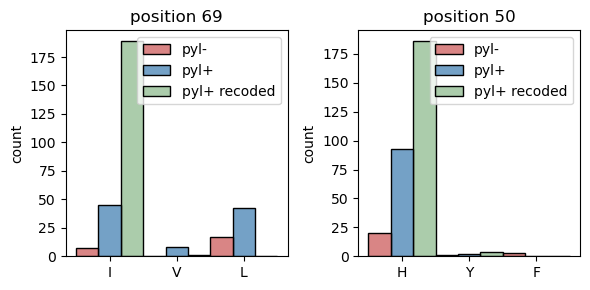

In [ ]:
def figure(alignment_df:pd.DataFrame, position:int=None, palette=palette, ax=None, field:str=None):
    # fig, (ax_top, ax_bottom) = get_split_figure((0, 0.0025), (0.97, 0.98))

    figure_df = alignment_df[[field, position]].copy()
    sns.histplot(figure_df, x=position, hue=field, multiple='dodge', ax=ax, palette=palette)
    ax.set_ylabel('count')
    # ax.set_yscale('log')
    ax.get_legend().set_title('')
    ax.set_xlabel('')
    ax.set_title(f'position {position}')

figure_df = alignment_df.copy()
figure_df['category'] = methanosarcinales_arf1_df.category 

palette = {'pyl+ recoded':'darkseagreen', 'pyl+':'steelblue', 'pyl-':'indianred'}
positions = np.argsort(diagonal_scores)[::-1][:10]
positions = [6, 13]
positions = [25, 136]
positions = [69, 50]
fig, axes = plt.subplots(ncols=len(positions), figsize=(3 * len(positions), 3))
for ax, position in zip(axes.ravel(), positions):
    figure(figure_df, position=position, ax=ax, field='category', palette=palette)
fig.tight_layout()
plt.show()

In [1]:
# Is there any interesting pattern in the co-occurrence of this residue? It doesn't seem to be particularly close to any of the stop codon recognition domains, as far as I can tell. 
no_pyl_idxs = np.where(~methanosarcinales_arf1_df.has_pyl)[0]
pyl_idxs = np.where(methanosarcinales_arf1_df.has_pyl)[0]
# h = mutual_information(alignment[pyl_idxs, :])
# h = mutual_information(alignment)

seq = ''.join(alignment[no_pyl_idxs, :][0])

def get_domain_boundaries(seq:str):
    patterns = dict()
    patterns['NIKS'] = 'NIKS'
    patterns['YxCxxxF'] = 'Y.C'
    patterns['GGQ'] = 'GGQ'
    patterns['GTS'] = 'GR.'

    boundaries = dict()
    for domain, pattern in patterns.items():
        start = re.search(pattern, seq).start()
        stop =  start + len(domain)
        print(f'get_domain_boundaries: {domain} boundaries {start}-{stop}.')
        boundaries[domain] = (start, stop)

domain_boundaries = get_domain_boundaries(seq)


NameError: name 'np' is not defined

In [ ]:
def plot_scores_2d(scores:np.ndarray, start=0, stop=150):

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('palette', ['white', 'steelblue'])

    fig, ax = plt.subplots(figsize=(25, 15))
    plt.imshow(scores[start:stop, start:stop], cmap=cmap)
    ax.set_yticks(np.arange(stop - start), labels=np.arange(start, stop), fontsize='x-small')
    ax.set_xticks(np.arange(start, stop), labels=np.arange(start, stop), fontsize='x-small')
    plt.show()


In [ ]:
if not os.path.exists('scores_order_2.txt'):
    cols = list(range(150)) + ['has_pyl']
    mask = alignment_df.category.isin(['pyl+ recoded', 'pyl-'])
    scores = get_scores(alignment_df[mask][cols].copy(), order=2)
    with open('scores_order_2.txt', 'w') as f:
        np.savetxt(f, scores)
scores = np.loadtxt('scores_order_2.txt')

In [ ]:
idxs = np.arange(len(scores.ravel()))
idxs = idxs[np.argsort(scores.ravel())[::-1]]
idxs = list(zip(*np.unravel_index(idxs, scores.shape)))

for i, j in idxs:
    if 13 not in [i, j]:
        print(i, j, scores[i, j])

25 136 1.1474609375
136 25 1.1474609375
59 69 1.1337890625
69 59 1.1337890625
66 69 1.12890625
69 66 1.12890625
69 63 1.125
63 69 1.125
50 69 1.1123046875
69 50 1.1123046875
7 5 1.107421875
5 7 1.107421875
78 69 1.0966796875
69 78 1.0966796875
11 7 1.095703125
7 12 1.095703125
7 11 1.095703125
7 10 1.095703125
7 16 1.095703125
9 7 1.095703125
36 7 1.095703125
64 7 1.095703125
65 7 1.095703125
7 141 1.095703125
146 7 1.095703125
145 7 1.095703125
7 140 1.095703125
55 7 1.095703125
7 85 1.095703125
7 91 1.095703125
7 94 1.095703125
71 7 1.095703125
7 82 1.095703125
56 7 1.095703125
7 120 1.095703125
7 116 1.095703125
7 109 1.095703125
7 132 1.095703125
7 100 1.095703125
7 89 1.095703125
7 118 1.095703125
100 7 1.095703125
7 119 1.095703125
26 7 1.095703125
124 7 1.095703125
52 7 1.095703125
57 7 1.095703125
7 23 1.095703125
7 15 1.095703125
7 0 1.095703125
10 7 1.095703125
147 7 1.095703125
140 7 1.095703125
7 76 1.095703125
16 7 1.095703125
7 68 1.095703125
122 7 1.095703125
7 64 1.0957

In [ ]:
diagonal_scores = np.diag(scores).ravel()
np.argsort(diagonal_scores)[::-1][:10]


array([ 13,   7,  88, 115,  69,  25, 108,   3,  79,  81, 104,  90, 106,
         4,  44, 134,   8, 127,  40,  14, 102,  47, 103,  97,  43,  86,
       101,  20,  92,  93,  77,  60, 105,  67,  74,  22,  99,  17,  80,
         2,  18,  98,  72, 137, 144,  48,  96,  95, 111, 135,  42, 143,
        21,  35,  39, 110,   1, 136, 114, 107,  51,  70,  59, 125, 142,
        24,  66,  63,  50, 123,  62,  78,  33, 128,  41, 131,  54,   5,
       138, 113, 117,  83,  84,  29, 139,  87,   6, 133,  45,  19,  30,
        38,  73, 112,  31, 129, 130,  53,  75, 121, 146, 145, 132, 141,
       140, 149, 148, 147, 122, 119, 118,  94, 116, 120, 124, 126, 109,
       100,  64,  65,  71,  68,  76,  91,  85,  82,  89,  57,  58,  61,
        56,  55,  52,  49,  32,  34,  37,  36,  46,  28,  26,  27,  16,
        23,   9,  12,  15,  10,  11,   0])

In [ ]:
scores[6, 13]

np.float64(1.2001953125)

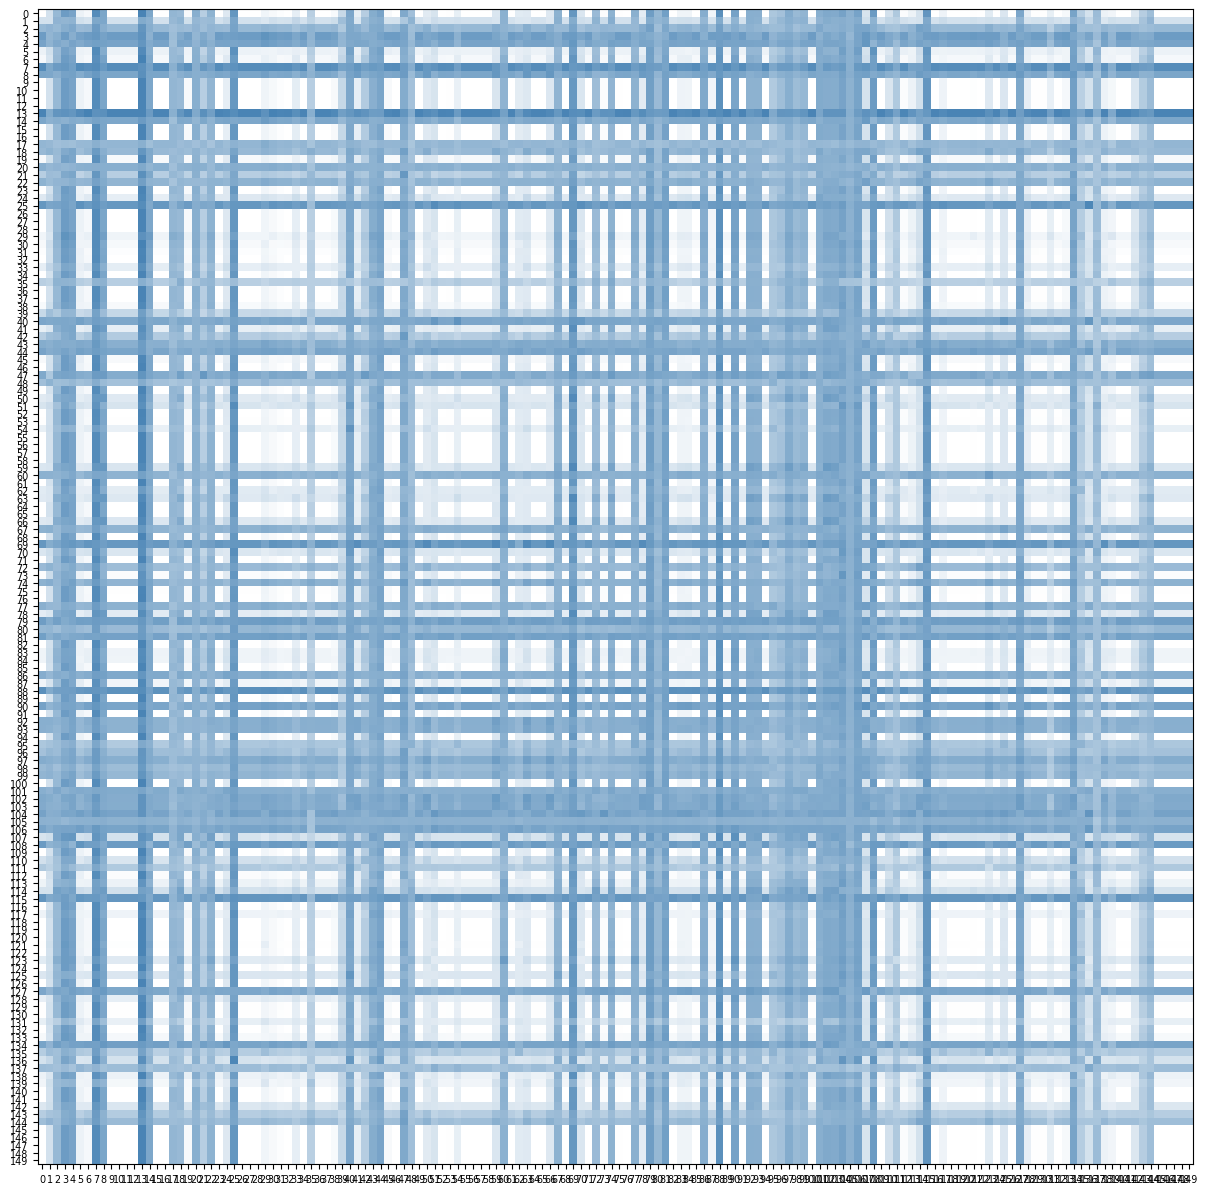

In [ ]:
figure(scores)

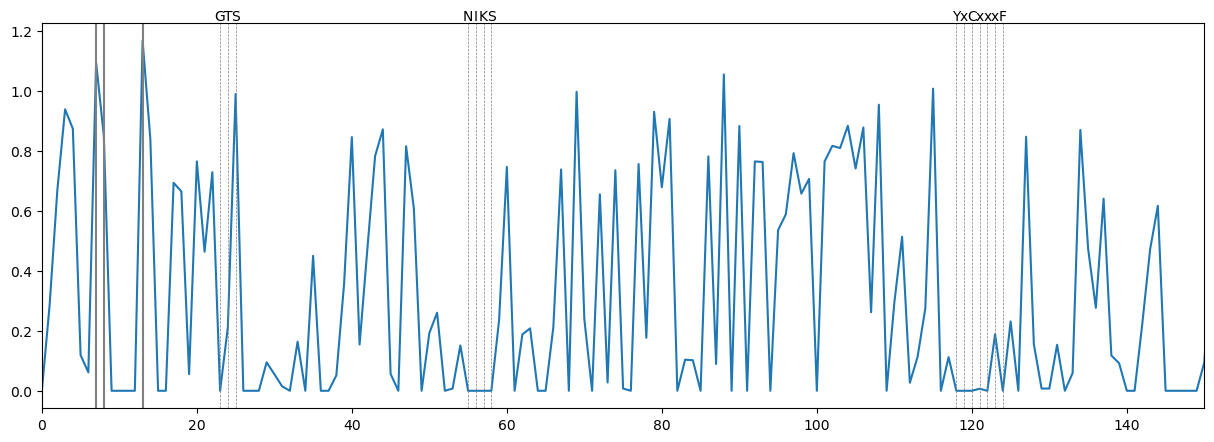

In [ ]:
alignment_length = alignment.shape[-1]
fig, ax = plt.subplots(figsize=(15, 5))

scores = get_scores(alignment_df[alignment_df.category.isin(['pyl+ recoded', 'pyl-'])], order=1)
sns.lineplot(x=np.arange(alignment_length), y=scores)
ax.set_xlim(xmin=0, xmax=150)

domains = dict()
domains['NIKS'] = np.arange(55, 59)
domains['YxCxxxF'] = np.arange(118, 126)
domains['GTS'] = np.arange(23, 26)

for domain, positions in domains.items():
    for x, aa in zip(positions, list(domain)):
        ax.text(x, ax.get_ylim()[-1], aa, ha='center', va='bottom')
        ax.axvline(x, ls='--', lw=0.5, color='gray')

ax.axvline(13, color='gray')
ax.axvline(7, color='gray')
ax.axvline(8, color='gray')
plt.show()
# What would be the maximum distance between two vectors that sum to one? sqrt(2)


In [ ]:
# No single signal, but perhaps if you look at the second-order scores, i.e. distribution of residue pairs?
# Worried about the mutual information metric, as it can be easily skewed by a single outlier